In [1]:
!git clone https://github.com/hkmztrk/DeepDTA.git

fatal: destination path 'DeepDTA' already exists and is not an empty directory.


In [2]:
%cd DeepDTA

/content/DeepDTA


In [3]:
data_dir = '/content/DeepDTA/data/kiba/'

In [4]:
!pip install rdkit
!pip install torch-geometric
!pip install lifelines

In [5]:
import pickle
import numpy as np

# Y = pickle.load(open("/content/DeepDTA/data/kiba/Y", "rb"))
Y = pickle.load(open("/content/DeepDTA/data/kiba/Y", "rb"), encoding='latin1')
label_row_inds, label_col_inds = np.where(np.isnan(Y)==False)

In [6]:
import os
import pickle
import json
import logging
from collections import OrderedDict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index


#all folds version

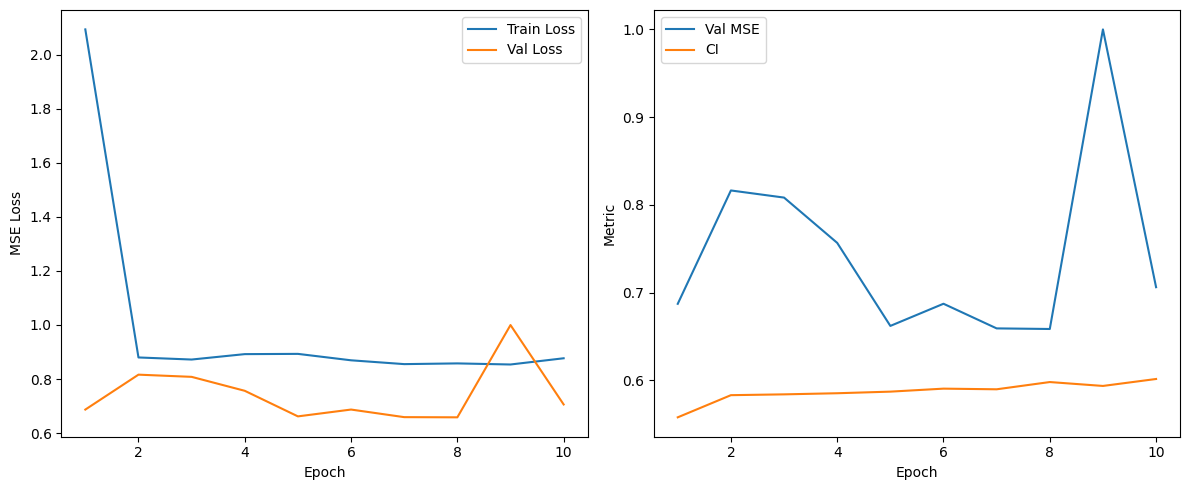

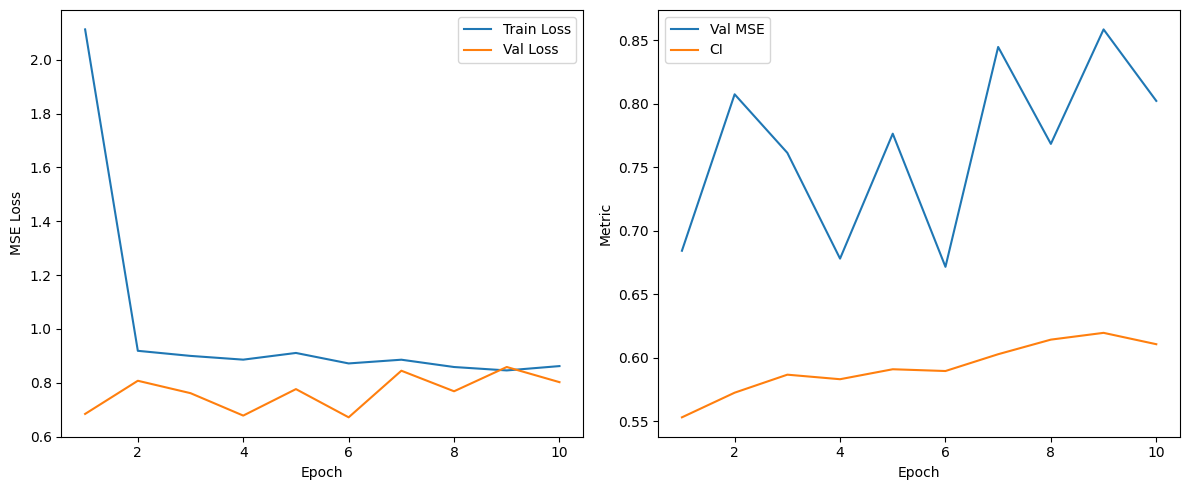

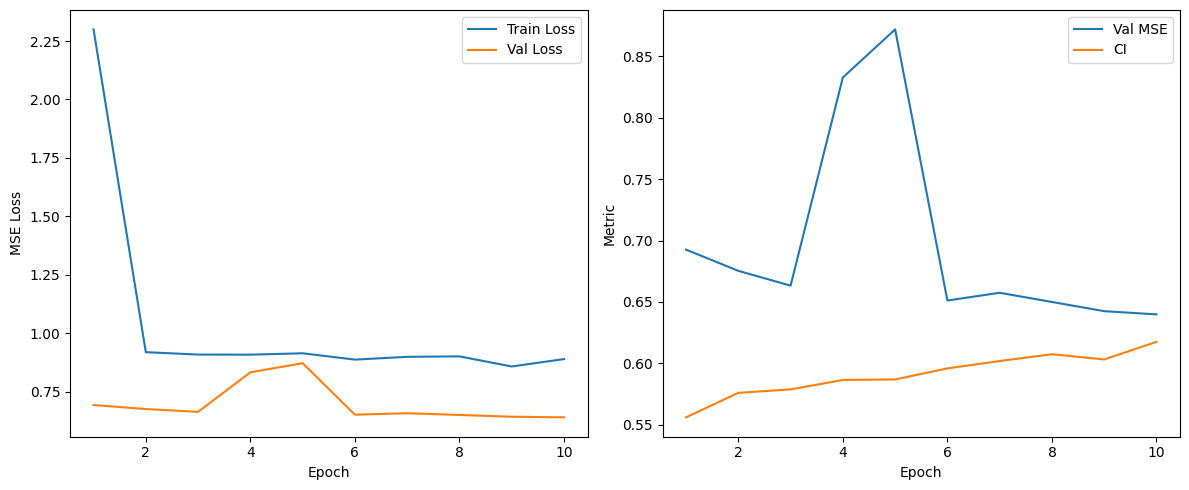

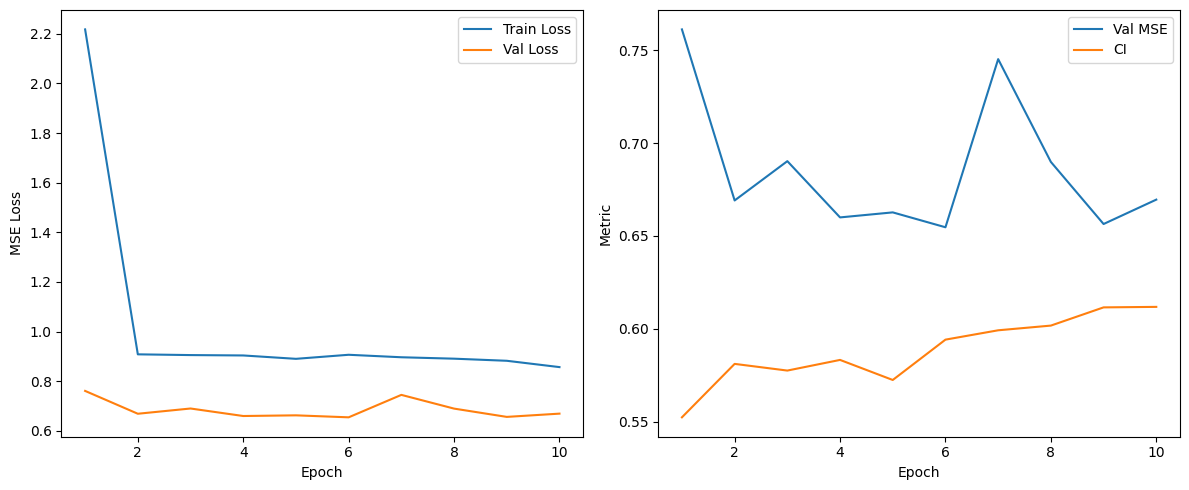

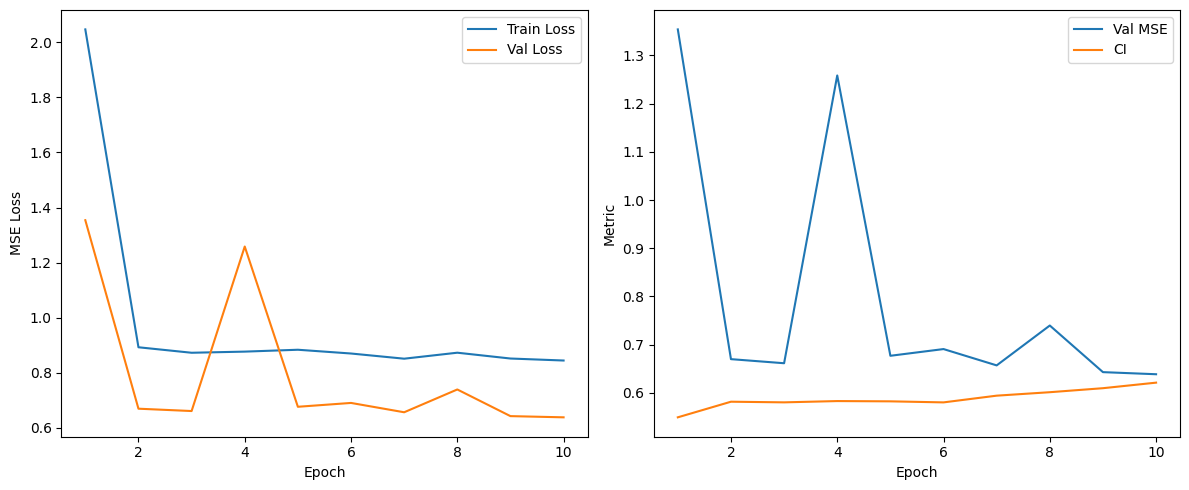

In [ ]:
# ===========================
# DeepDTA + GCN — Fixed Script
# ===========================

import os
import pickle
import json
import logging
from collections import OrderedDict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index

# -----------------
# Logging
# -----------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("DeepDTA-GCN")

# -----------------
# Reproducibility
# -----------------
def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------
# Constants & vocab
# -----------------
MAX_SEQ_LEN = 1000  # protein sequence max length (pad/truncate)
# Include 'X' as explicit padding/unknown token at the end
protein_chars = 'ACDEFGHIKLMNPQRSTVWYX'
protein_dict = {char: idx for idx, char in enumerate(protein_chars)}
PADDING_IDX = protein_dict['X']  # used in Embedding(padding_idx=...)

# -----------------
# SMILES -> Graph
# -----------------
def smiles_to_graph(smiles: str) -> Data | None:
    """
    Convert a SMILES string into a PyG Data graph:
    - Node feature: atomic number (shape [N,1])
    - Edge index: bidirectional edges
    - Edge weight: bond order (float), 1-D (shape [E,])
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features: atomic numbers as a single scalar channel
    atom_features = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long).view(-1, 1)

    # Bond edges (bidirectional) and weights
    edge_u, edge_v, edge_w = [], [], []
    for bond in mol.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        w = float(bond.GetBondTypeAsDouble())
        # add both directions
        edge_u.extend([u, v])
        edge_v.extend([v, u])
        edge_w.extend([w, w])

    if len(edge_u) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.empty((0,), dtype=torch.float32)
    else:
        edge_index = torch.tensor([edge_u, edge_v], dtype=torch.long)
        edge_weight = torch.tensor(edge_w, dtype=torch.float32)  # 1-D, as GCNConv expects edge_weight

    return Data(x=atom_features, edge_index=edge_index, edge_weight=edge_weight)

# -----------------
# Dataset
# -----------------
class DrugTargetDataset(Dataset):
    def __init__(self, drug_graphs, protein_indices, labels):
        """
        drug_graphs: list[PyG Data]
        protein_indices: np.ndarray of shape [N, MAX_SEQ_LEN], dtype=int
        labels: np.ndarray of shape [N], dtype=float
        """
        self.drug_graphs = drug_graphs
        self.protein_indices = protein_indices
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        drug_graph = self.drug_graphs[idx]
        protein = torch.tensor(self.protein_indices[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return drug_graph, protein, label

# -----------------
# Collate for PyG + tensors
# -----------------
def custom_collate(batch):
    """
    batch: list of tuples (drug_graph, protein, label)
    """
    drug_graphs = [item[0] for item in batch]
    proteins = torch.stack([item[1] for item in batch], dim=0)  # [B, L]
    labels = torch.stack([item[2] for item in batch], dim=0)    # [B]
    batched_drug_graph = Batch.from_data_list(drug_graphs)
    return batched_drug_graph, proteins, labels

# -----------------
# Protein sequence -> indices
# -----------------
def convert_protein_to_int(protein: str) -> list[int]:
    """
    Truncate/pad to MAX_SEQ_LEN using 'X' as padding/unknown.
    """
    protein = (protein or "")
    padded = list(protein[:MAX_SEQ_LEN].ljust(MAX_SEQ_LEN, 'X'))
    return [protein_dict.get(aa, PADDING_IDX) for aa in padded]

# -----------------
# Model
# -----------------
class GCNModel(nn.Module):
    def __init__(self, num_protein_features: int, embedding_dim: int, num_filters: int, dropout: float = 0.1):
        super().__init__()
        # Drug branch
        self.conv1 = GCNConv(1, num_filters)            # input node feature dim = 1
        self.conv2 = GCNConv(num_filters, num_filters*2)

        # Protein branch
        self.protein_embedding = nn.Embedding(num_protein_features, embedding_dim, padding_idx=PADDING_IDX)

        # Fusion MLP
        self.fc1 = nn.Linear(num_filters*2 + embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

        self.dropout = nn.Dropout(dropout)

    def masked_mean(self, emb: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        """
        emb: [B, L, D], mask: [B, L] with True for valid tokens (not padding)
        Returns: [B, D]
        """
        mask = mask.unsqueeze(-1)  # [B, L, 1]
        sum_emb = (emb * mask).sum(dim=1)                # [B, D]
        lengths = mask.sum(dim=1).clamp(min=1)           # [B, 1]
        return sum_emb / lengths

    def forward(self, drug_graph: Batch, protein_data: torch.Tensor) -> torch.Tensor:
        # Drug graph
        x = drug_graph.x.float()                         # [total_nodes, 1]
        edge_index = drug_graph.edge_index               # [2, E]
        edge_weight = getattr(drug_graph, "edge_weight", None)  # [E,] or None
        batch_index = drug_graph.batch                   # [total_nodes]

        h = torch.relu(self.conv1(x, edge_index, edge_weight))
        h = torch.relu(self.conv2(h, edge_index, edge_weight))
        drug_out = global_mean_pool(h, batch_index)      # [B, 2*num_filters]

        # Protein branch
        prot_emb = self.protein_embedding(protein_data)  # [B, L, D]
        mask = (protein_data != PADDING_IDX)             # [B, L]
        protein_out = self.masked_mean(prot_emb, mask)   # [B, D]

        # Fusion
        combined = torch.cat([drug_out, protein_out], dim=1)  # [B, 2F + D]
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x).squeeze(-1)                      # [B]
        return x

# -----------------
# Train / Validate
# -----------------
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device=None, plot=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, val_mse_list, val_ci_list = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        for drug_graph, protein, label in train_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = model(drug_graph, protein)          # [B]
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running += loss.item()

        epoch_loss = running / max(1, len(train_loader))
        train_losses.append(epoch_loss)
        logger.info(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

        vloss, vmse, vci = validate_model(model, val_loader, device=device)
        val_losses.append(vloss)
        val_mse_list.append(vmse)
        val_ci_list.append(vci)
        logger.info(f"Epoch {epoch}/{num_epochs} - Val Loss: {vloss:.4f} | Val MSE: {vmse:.4f} | CI: {vci:.4f}")

    if plot:
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(12,5))
        # Losses
        plt.subplot(1,2,1)
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, val_losses, label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        # Metrics
        plt.subplot(1,2,2)
        plt.plot(epochs, val_mse_list, label="Val MSE")
        plt.plot(epochs, val_ci_list, label="CI")
        plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.legend()
        plt.tight_layout()
        plt.show()

    return train_losses, val_losses, val_mse_list, val_ci_list

def validate_model(model, val_loader, device=None):
    device = device or next(model.parameters()).device
    model.eval()
    criterion = nn.MSELoss()
    running = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for drug_graph, protein, label in val_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            outputs = model(drug_graph, protein)          # [B]
            loss = criterion(outputs, label)
            running += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_labels.append(label.detach().cpu().numpy())

    val_loss = running / max(1, len(val_loader))
    all_preds = np.concatenate(all_preds, axis=0) if len(all_preds) > 0 else np.array([])
    all_labels = np.concatenate(all_labels, axis=0) if len(all_labels) > 0 else np.array([])

    if all_preds.size == 0:
        return val_loss, float('nan'), float('nan')

    mse = mean_squared_error(all_labels, all_preds)
    # For KIBA (higher=better), this direction is correct:
    ci = concordance_index(all_labels, all_preds)

    return val_loss, mse, ci

# -----------------
# KIBA Loading
# -----------------
def load_kiba_data(dataset_dir: str):
    """
    Loads ligands, proteins, and Y matrix.
    Produces flattened, aligned arrays (drug_graphs, protein_indices, labels)
    for each observed (non-NaN) entry in Y, preserving original pair order.
    Also returns a mapping from original flattened index -> new index after
    filtering invalid SMILES.
    """
    lig_path = os.path.join(dataset_dir, "ligands_can.txt")
    prot_path = os.path.join(dataset_dir, "proteins.txt")
    y_path = os.path.join(dataset_dir, "Y")

    # Load ligand SMILES and protein sequences
    with open(lig_path, "r") as f:
        ligands = json.load(f, object_pairs_hook=OrderedDict)
    with open(prot_path, "r") as f:
        proteins = json.load(f, object_pairs_hook=OrderedDict)

    # Load Y (KIBA score matrix)
    with open(y_path, "rb") as f:
        Y = pickle.load(f, encoding='latin1')

    # Find observed entries
    row_inds, col_inds = np.where(~np.isnan(Y))

    drug_keys = list(ligands.keys())
    protein_keys = list(proteins.keys())

    drug_graphs, protein_indices, labels = [], [], []
    old_to_new = {}
    kept = 0

    for old_idx, (r, c) in enumerate(zip(row_inds, col_inds)):
        smi = ligands[drug_keys[r]]
        g = smiles_to_graph(smi)
        if g is None:
            # skip invalid SMILES
            continue
        prot_seq = proteins[protein_keys[c]]
        p_idx = convert_protein_to_int(prot_seq)

        drug_graphs.append(g)
        protein_indices.append(p_idx)
        labels.append(float(Y[r, c]))
        old_to_new[old_idx] = kept
        kept += 1

    drug_graphs = drug_graphs
    protein_indices = np.array(protein_indices, dtype=np.int64)
    labels = np.array(labels, dtype=np.float32)

    dropped = len(row_inds) - kept
    if dropped > 0:
        logger.warning(f"Filtered out {dropped} pairs due to invalid SMILES; kept {kept}.")

    return drug_graphs, protein_indices, labels, old_to_new

# -----------------
# Fold Loading & Remapping
# -----------------
def load_folds(dataset_dir: str):
    test_path = os.path.join(dataset_dir, "folds", "test_fold_setting1.txt")
    train_path = os.path.join(dataset_dir, "folds", "train_fold_setting1.txt")
    with open(test_path, "r") as f:
        test_fold = json.load(f)          # list[int] of old flattened indices
    with open(train_path, "r") as f:
        train_folds = json.load(f)        # list[list[int]] of old flattened indices
    return test_fold, train_folds

def remap_indices(old_indices: list[int], mapping: dict[int, int]) -> list[int]:
    """Remap old flattened indices to new ones after filtering; drops any missing."""
    return [mapping[i] for i in old_indices if i in mapping]

def remap_folds(test_fold, train_folds, old_to_new):
    new_test = remap_indices(test_fold, old_to_new)
    new_trains = [remap_indices(tr_idx, old_to_new) for tr_idx in train_folds]
    dropped_test = len(test_fold) - len(new_test)
    dropped_tr = sum(len(tr) for tr in train_folds) - sum(len(tr) for tr in new_trains)
    if dropped_test or dropped_tr:
        logger.warning(f"Folds remapped: dropped {dropped_test} test and {dropped_tr} train indices due to filtered pairs.")
    return new_test, new_trains

# -----------------
# Main Experiment
# -----------------
def run_experiment(num_epochs=10, batch_size=32, lr=1e-3, dataset_dir='/content/DeepDTA/data/kiba/'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Load data
    drug_graphs, protein_indices, labels, old_to_new = load_kiba_data(dataset_dir)
    if len(labels) == 0:
        logger.error("No data available after loading/filtering. Exiting.")
        return

    # Load & remap folds to filtered indices
    test_fold_old, train_folds_old = load_folds(dataset_dir)
    test_fold, train_folds = remap_folds(test_fold_old, train_folds_old, old_to_new)

    if len(test_fold) == 0:
        logger.error("Empty test fold after remapping. Exiting.")
        return

    # Build test dataset/loader once (fixed test split)
    test_drugs = [drug_graphs[i] for i in test_fold]
    test_prots = protein_indices[test_fold]
    test_labels = labels[test_fold]
    test_dataset = DrugTargetDataset(test_drugs, test_prots, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    # Model hyperparams
    num_protein_features = len(protein_dict)  # 21 including X
    embedding_dim = 128
    num_filters = 32

    # Train one model per train fold
    for fold_idx, train_indices in enumerate(train_folds, start=1):
        if len(train_indices) == 0:
            logger.warning(f"Train fold {fold_idx} is empty after remapping. Skipping.")
            continue

        logger.info(f"=== Fold {fold_idx} | Train size: {len(train_indices)} | Test size: {len(test_fold)} ===")

        train_drugs = [drug_graphs[i] for i in train_indices]
        train_prots = protein_indices[train_indices]
        train_labels = labels[train_indices]
        train_dataset = DrugTargetDataset(train_drugs, train_prots, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

        model = GCNModel(num_protein_features=num_protein_features,
                         embedding_dim=embedding_dim,
                         num_filters=num_filters,
                         dropout=0.1)

        train_model(model, train_loader, test_loader, num_epochs=num_epochs, lr=lr, device=device, plot=True)

# -----------------
# Run
# -----------------
run_experiment(num_epochs=10, batch_size=32, lr=1e-3, dataset_dir='/content/DeepDTA/data/kiba/')


#1 fold version

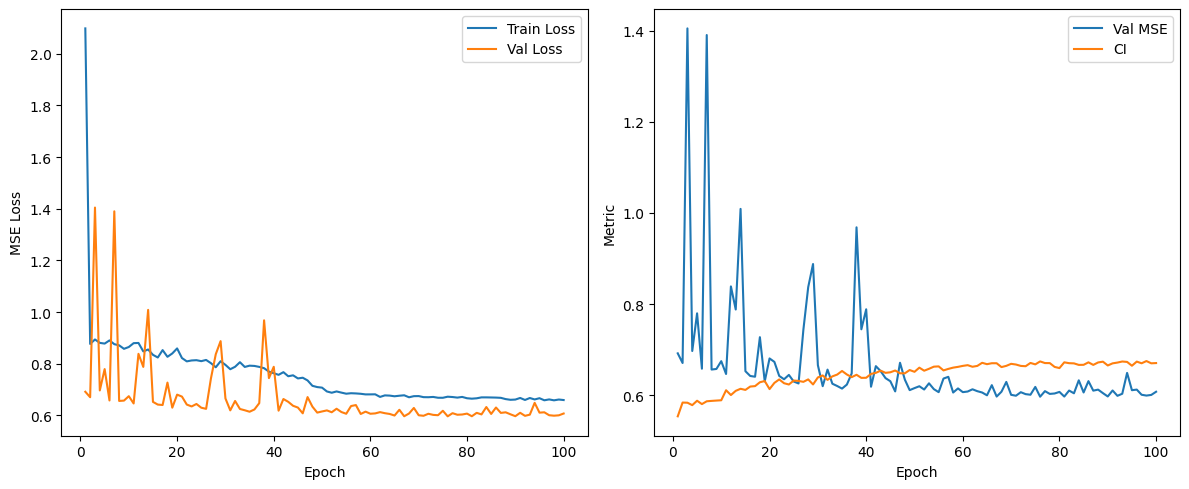

In [ ]:
# ===========================
# DeepDTA + GCN — Single-Fold Script
# ===========================

import os
import pickle
import json
import logging
from collections import OrderedDict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index

# -----------------
# Logging
# -----------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("DeepDTA-GCN")

# -----------------
# Reproducibility
# -----------------
def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------
# Constants & vocab
# -----------------
MAX_SEQ_LEN = 1000  # protein sequence max length (pad/truncate)
# Include 'X' as explicit padding/unknown token at the end
protein_chars = 'ACDEFGHIKLMNPQRSTVWYX'
protein_dict = {char: idx for idx, char in enumerate(protein_chars)}
PADDING_IDX = protein_dict['X']  # used in Embedding(padding_idx=...)

# -----------------
# SMILES -> Graph
# -----------------
def smiles_to_graph(smiles: str) -> Data | None:
    """
    Convert a SMILES string into a PyG Data graph:
    - Node feature: atomic number (shape [N,1])
    - Edge index: bidirectional edges
    - Edge weight: bond order (float), 1-D (shape [E,])
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features: atomic numbers as a single scalar channel
    atom_features = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long).view(-1, 1)

    # Bond edges (bidirectional) and weights
    edge_u, edge_v, edge_w = [], [], []
    for bond in mol.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        w = float(bond.GetBondTypeAsDouble())
        edge_u.extend([u, v])
        edge_v.extend([v, u])
        edge_w.extend([w, w])

    if len(edge_u) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.empty((0,), dtype=torch.float32)
    else:
        edge_index = torch.tensor([edge_u, edge_v], dtype=torch.long)
        edge_weight = torch.tensor(edge_w, dtype=torch.float32)

    return Data(x=atom_features, edge_index=edge_index, edge_weight=edge_weight)

# -----------------
# Dataset
# -----------------
class DrugTargetDataset(Dataset):
    def __init__(self, drug_graphs, protein_indices, labels):
        self.drug_graphs = drug_graphs
        self.protein_indices = protein_indices
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        drug_graph = self.drug_graphs[idx]
        protein = torch.tensor(self.protein_indices[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return drug_graph, protein, label

# -----------------
# Collate for PyG + tensors
# -----------------
def custom_collate(batch):
    drug_graphs = [item[0] for item in batch]
    proteins = torch.stack([item[1] for item in batch], dim=0)  # [B, L]
    labels = torch.stack([item[2] for item in batch], dim=0)    # [B]
    batched_drug_graph = Batch.from_data_list(drug_graphs)
    return batched_drug_graph, proteins, labels

# -----------------
# Protein sequence -> indices
# -----------------
def convert_protein_to_int(protein: str) -> list[int]:
    protein = (protein or "")
    padded = list(protein[:MAX_SEQ_LEN].ljust(MAX_SEQ_LEN, 'X'))
    return [protein_dict.get(aa, PADDING_IDX) for aa in padded]

# -----------------
# Model
# -----------------
class GCNModel(nn.Module):
    def __init__(self, num_protein_features: int, embedding_dim: int, num_filters: int, dropout: float = 0.1):
        super().__init__()
        # Drug branch
        self.conv1 = GCNConv(1, num_filters)            # input node feature dim = 1
        self.conv2 = GCNConv(num_filters, num_filters*2)

        # Protein branch
        self.protein_embedding = nn.Embedding(num_protein_features, embedding_dim, padding_idx=PADDING_IDX)

        # Fusion MLP
        self.fc1 = nn.Linear(num_filters*2 + embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

        self.dropout = nn.Dropout(dropout)

    def masked_mean(self, emb: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        mask = mask.unsqueeze(-1)  # [B, L, 1]
        sum_emb = (emb * mask).sum(dim=1)                # [B, D]
        lengths = mask.sum(dim=1).clamp(min=1)           # [B, 1]
        return sum_emb / lengths

    def forward(self, drug_graph: Batch, protein_data: torch.Tensor) -> torch.Tensor:
        # Drug graph
        x = drug_graph.x.float()                         # [total_nodes, 1]
        edge_index = drug_graph.edge_index               # [2, E]
        edge_weight = getattr(drug_graph, "edge_weight", None)  # [E,] or None
        batch_index = drug_graph.batch                   # [total_nodes]

        h = torch.relu(self.conv1(x, edge_index, edge_weight))
        h = torch.relu(self.conv2(h, edge_index, edge_weight))
        drug_out = global_mean_pool(h, batch_index)      # [B, 2*num_filters]

        # Protein branch
        prot_emb = self.protein_embedding(protein_data)  # [B, L, D]
        mask = (protein_data != PADDING_IDX)             # [B, L]
        protein_out = self.masked_mean(prot_emb, mask)   # [B, D]

        # Fusion
        combined = torch.cat([drug_out, protein_out], dim=1)  # [B, 2F + D]
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x).squeeze(-1)                      # [B]
        return x

# -----------------
# Train / Validate
# -----------------
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device=None, plot=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, val_mse_list, val_ci_list = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        for drug_graph, protein, label in train_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = model(drug_graph, protein)          # [B]
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running += loss.item()

        epoch_loss = running / max(1, len(train_loader))
        train_losses.append(epoch_loss)
        logger.info(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

        vloss, vmse, vci = validate_model(model, val_loader, device=device)
        val_losses.append(vloss)
        val_mse_list.append(vmse)
        val_ci_list.append(vci)
        logger.info(f"Epoch {epoch}/{num_epochs} - Val Loss: {vloss:.4f} | Val MSE: {vmse:.4f} | CI: {vci:.4f}")

    if plot:
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(12,5))
        # Losses
        plt.subplot(1,2,1)
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, val_losses, label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        # Metrics
        plt.subplot(1,2,2)
        plt.plot(epochs, val_mse_list, label="Val MSE")
        plt.plot(epochs, val_ci_list, label="CI")
        plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.legend()
        plt.tight_layout()
        plt.show()

    return train_losses, val_losses, val_mse_list, val_ci_list

def validate_model(model, val_loader, device=None):
    device = device or next(model.parameters()).device
    model.eval()
    criterion = nn.MSELoss()
    running = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for drug_graph, protein, label in val_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            outputs = model(drug_graph, protein)          # [B]
            loss = criterion(outputs, label)
            running += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_labels.append(label.detach().cpu().numpy())

    val_loss = running / max(1, len(val_loader))
    all_preds = np.concatenate(all_preds, axis=0) if len(all_preds) > 0 else np.array([])
    all_labels = np.concatenate(all_labels, axis=0) if len(all_labels) > 0 else np.array([])

    if all_preds.size == 0:
        return val_loss, float('nan'), float('nan')

    mse = mean_squared_error(all_labels, all_preds)
    # For KIBA (higher=better), this direction is correct:
    ci = concordance_index(all_labels, all_preds)

    return val_loss, mse, ci

# -----------------
# KIBA Loading
# -----------------
def load_kiba_data(dataset_dir: str):
    lig_path = os.path.join(dataset_dir, "ligands_can.txt")
    prot_path = os.path.join(dataset_dir, "proteins.txt")
    y_path = os.path.join(dataset_dir, "Y")

    with open(lig_path, "r") as f:
        ligands = json.load(f, object_pairs_hook=OrderedDict)
    with open(prot_path, "r") as f:
        proteins = json.load(f, object_pairs_hook=OrderedDict)

    with open(y_path, "rb") as f:
        Y = pickle.load(f, encoding='latin1')

    row_inds, col_inds = np.where(~np.isnan(Y))

    drug_keys = list(ligands.keys())
    protein_keys = list(proteins.keys())

    drug_graphs, protein_indices, labels = [], [], []
    old_to_new = {}
    kept = 0

    for old_idx, (r, c) in enumerate(zip(row_inds, col_inds)):
        smi = ligands[drug_keys[r]]
        g = smiles_to_graph(smi)
        if g is None:
            continue
        prot_seq = proteins[protein_keys[c]]
        p_idx = convert_protein_to_int(prot_seq)

        drug_graphs.append(g)
        protein_indices.append(p_idx)
        labels.append(float(Y[r, c]))
        old_to_new[old_idx] = kept
        kept += 1

    protein_indices = np.array(protein_indices, dtype=np.int64)
    labels = np.array(labels, dtype=np.float32)

    dropped = len(row_inds) - kept
    if dropped > 0:
        logger.warning(f"Filtered out {dropped} pairs due to invalid SMILES; kept {kept}.")

    return drug_graphs, protein_indices, labels, old_to_new

# -----------------
# Fold Loading & Remapping
# -----------------
def load_folds(dataset_dir: str):
    test_path = os.path.join(dataset_dir, "folds", "test_fold_setting1.txt")
    train_path = os.path.join(dataset_dir, "folds", "train_fold_setting1.txt")
    with open(test_path, "r") as f:
        test_fold = json.load(f)          # list[int] (old flattened indices)
    with open(train_path, "r") as f:
        train_folds = json.load(f)        # list[list[int]] (old flattened indices)
    return test_fold, train_folds

def remap_indices(old_indices: list[int], mapping: dict[int, int]) -> list[int]:
    return [mapping[i] for i in old_indices if i in mapping]

def remap_folds(test_fold, train_folds, old_to_new):
    new_test = remap_indices(test_fold, old_to_new)
    new_trains = [remap_indices(tr_idx, old_to_new) for tr_idx in train_folds]
    dropped_test = len(test_fold) - len(new_test)
    dropped_tr = sum(len(tr) for tr in train_folds) - sum(len(tr) for tr in new_trains)
    if dropped_test or dropped_tr:
        logger.warning(f"Folds remapped: dropped {dropped_test} test and {dropped_tr} train indices due to filtered pairs.")
    return new_test, new_trains

# -----------------
# Main Experiment (Single Fold)
# -----------------
def run_experiment(num_epochs=10, batch_size=32, lr=1e-3,
                   dataset_dir='/content/DeepDTA/data/kiba/',
                   fold_to_run: int = 0):
    """
    Train and evaluate on a single train fold (specified by fold_to_run),
    using the same fixed test fold.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Load data
    drug_graphs, protein_indices, labels, old_to_new = load_kiba_data(dataset_dir)
    if len(labels) == 0:
        logger.error("No data available after loading/filtering. Exiting.")
        return

    # Load & remap folds to filtered indices
    test_fold_old, train_folds_old = load_folds(dataset_dir)
    test_fold, train_folds = remap_folds(test_fold_old, train_folds_old, old_to_new)

    if len(test_fold) == 0:
        logger.error("Empty test fold after remapping. Exiting.")
        return
    if not (0 <= fold_to_run < len(train_folds)):
        logger.error(f"fold_to_run={fold_to_run} out of range (0..{len(train_folds)-1}). Exiting.")
        return

    # Build test dataset/loader (fixed test split)
    test_drugs = [drug_graphs[i] for i in test_fold]
    test_prots = protein_indices[test_fold]
    test_labels = labels[test_fold]
    test_dataset = DrugTargetDataset(test_drugs, test_prots, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    # Select single train fold
    train_indices = train_folds[fold_to_run]
    if len(train_indices) == 0:
        logger.error(f"Selected train fold {fold_to_run} is empty after remapping. Exiting.")
        return

    logger.info(f"=== Single Fold {fold_to_run} | Train size: {len(train_indices)} | Test size: {len(test_fold)} ===")

    train_drugs = [drug_graphs[i] for i in train_indices]
    train_prots = protein_indices[train_indices]
    train_labels = labels[train_indices]
    train_dataset = DrugTargetDataset(train_drugs, train_prots, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    # Model hyperparams
    num_protein_features = len(protein_dict)  # 21 including X
    embedding_dim = 128
    num_filters = 32

    model = GCNModel(num_protein_features=num_protein_features,
                     embedding_dim=embedding_dim,
                     num_filters=num_filters,
                     dropout=0.1)

    train_model(model, train_loader, test_loader, num_epochs=num_epochs, lr=lr, device=device, plot=True)

# -----------------
# Run example (uncomment)
# -----------------
run_experiment(num_epochs=100, batch_size=32, lr=1e-3, dataset_dir='/content/DeepDTA/data/kiba/', fold_to_run=0)


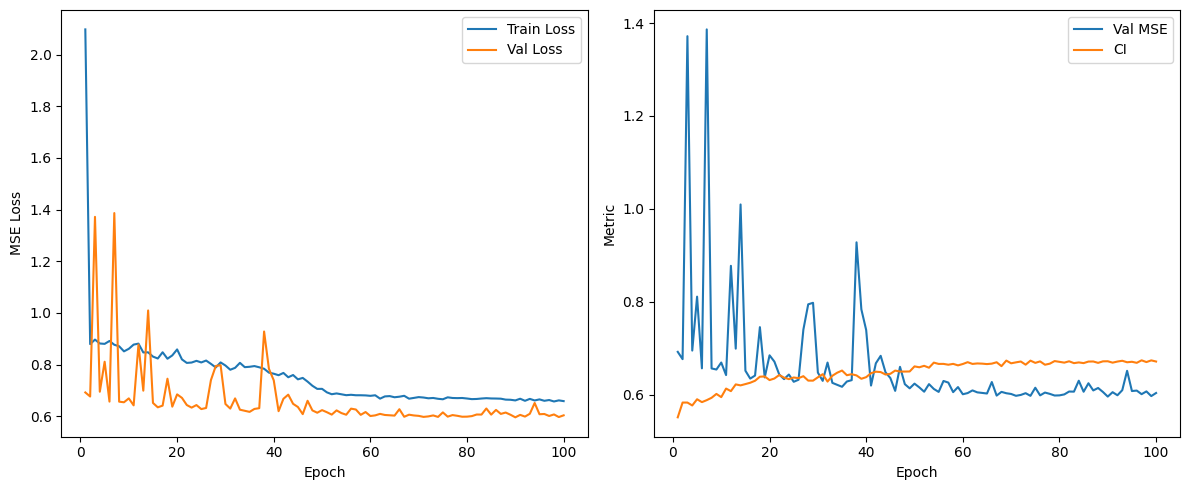

In [ ]:
# ===========================
# DeepDTA + GCN — Single-Fold Script (Dynamic MAX_SEQ_LEN)
# ===========================

import os
import pickle
import json
import logging
from collections import OrderedDict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index

# -----------------
# Logging
# -----------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("DeepDTA-GCN")

# -----------------
# Reproducibility
# -----------------
def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------
# Protein vocab (includes padding 'X')
# -----------------
protein_chars = 'ACDEFGHIKLMNPQRSTVWYX'
protein_dict = {char: idx for idx, char in enumerate(protein_chars)}
PADDING_IDX = protein_dict['X']  # used in Embedding(padding_idx=...)

# -----------------
# SMILES -> Graph
# -----------------
def smiles_to_graph(smiles: str) -> Data | None:
    """
    Convert a SMILES string into a PyG Data graph:
    - Node feature: atomic number (shape [N,1])
    - Edge index: bidirectional edges
    - Edge weight: bond order (float), 1-D (shape [E,])
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long).view(-1, 1)

    edge_u, edge_v, edge_w = [], [], []
    for bond in mol.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        w = float(bond.GetBondTypeAsDouble())
        edge_u.extend([u, v])
        edge_v.extend([v, u])
        edge_w.extend([w, w])

    if len(edge_u) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.empty((0,), dtype=torch.float32)
    else:
        edge_index = torch.tensor([edge_u, edge_v], dtype=torch.long)
        edge_weight = torch.tensor(edge_w, dtype=torch.float32)

    return Data(x=atom_features, edge_index=edge_index, edge_weight=edge_weight)

# -----------------
# Dataset
# -----------------
class DrugTargetDataset(Dataset):
    def __init__(self, drug_graphs, protein_indices, labels):
        self.drug_graphs = drug_graphs
        self.protein_indices = protein_indices
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        drug_graph = self.drug_graphs[idx]
        protein = torch.tensor(self.protein_indices[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return drug_graph, protein, label

# -----------------
# Collate for PyG + tensors
# -----------------
def custom_collate(batch):
    drug_graphs = [item[0] for item in batch]
    proteins = torch.stack([item[1] for item in batch], dim=0)  # [B, L]
    labels = torch.stack([item[2] for item in batch], dim=0)    # [B]
    batched_drug_graph = Batch.from_data_list(drug_graphs)
    return batched_drug_graph, proteins, labels

# -----------------
# Protein sequence -> indices (uses dynamic max_seq_len)
# -----------------
def convert_protein_to_int(protein: str, max_seq_len: int) -> list[int]:
    protein = (protein or "")
    padded = list(protein[:max_seq_len].ljust(max_seq_len, 'X'))
    return [protein_dict.get(aa, PADDING_IDX) for aa in padded]

# -----------------
# Model
# -----------------
class GCNModel(nn.Module):
    def __init__(self, num_protein_features: int, embedding_dim: int, num_filters: int, dropout: float = 0.1):
        super().__init__()
        # Drug branch
        self.conv1 = GCNConv(1, num_filters)
        self.conv2 = GCNConv(num_filters, num_filters*2)

        # Protein branch
        self.protein_embedding = nn.Embedding(num_protein_features, embedding_dim, padding_idx=PADDING_IDX)

        # Fusion MLP
        self.fc1 = nn.Linear(num_filters*2 + embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

        self.dropout = nn.Dropout(dropout)

    def masked_mean(self, emb: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        mask = mask.unsqueeze(-1)  # [B, L, 1]
        sum_emb = (emb * mask).sum(dim=1)                # [B, D]
        lengths = mask.sum(dim=1).clamp(min=1)           # [B, 1]
        return sum_emb / lengths

    def forward(self, drug_graph: Batch, protein_data: torch.Tensor) -> torch.Tensor:
        # Drug graph
        x = drug_graph.x.float()
        edge_index = drug_graph.edge_index
        edge_weight = getattr(drug_graph, "edge_weight", None)
        batch_index = drug_graph.batch

        h = torch.relu(self.conv1(x, edge_index, edge_weight))
        h = torch.relu(self.conv2(h, edge_index, edge_weight))
        drug_out = global_mean_pool(h, batch_index)      # [B, 2*num_filters]

        # Protein branch
        prot_emb = self.protein_embedding(protein_data)  # [B, L, D]
        mask = (protein_data != PADDING_IDX)             # [B, L]
        protein_out = self.masked_mean(prot_emb, mask)   # [B, D]

        # Fusion
        combined = torch.cat([drug_out, protein_out], dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x).squeeze(-1)                      # [B]
        return x

# -----------------
# Train / Validate
# -----------------
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device=None, plot=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, val_mse_list, val_ci_list = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        for drug_graph, protein, label in train_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = model(drug_graph, protein)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running += loss.item()

        epoch_loss = running / max(1, len(train_loader))
        train_losses.append(epoch_loss)
        logger.info(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

        vloss, vmse, vci = validate_model(model, val_loader, device=device)
        val_losses.append(vloss)
        val_mse_list.append(vmse)
        val_ci_list.append(vci)
        logger.info(f"Epoch {epoch}/{num_epochs} - Val Loss: {vloss:.4f} | Val MSE: {vmse:.4f} | CI: {vci:.4f}")

    if plot:
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, val_losses, label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        plt.subplot(1,2,2)
        plt.plot(epochs, val_mse_list, label="Val MSE")
        plt.plot(epochs, val_ci_list, label="CI")
        plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.legend()
        plt.tight_layout()
        plt.show()

    return train_losses, val_losses, val_mse_list, val_ci_list

def validate_model(model, val_loader, device=None):
    device = device or next(model.parameters()).device
    model.eval()
    criterion = nn.MSELoss()
    running = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for drug_graph, protein, label in val_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            outputs = model(drug_graph, protein)
            loss = criterion(outputs, label)
            running += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_labels.append(label.detach().cpu().numpy())

    val_loss = running / max(1, len(val_loader))
    all_preds = np.concatenate(all_preds, axis=0) if len(all_preds) > 0 else np.array([])
    all_labels = np.concatenate(all_labels, axis=0) if len(all_labels) > 0 else np.array([])

    if all_preds.size == 0:
        return val_loss, float('nan'), float('nan')

    mse = mean_squared_error(all_labels, all_preds)
    ci = concordance_index(all_labels, all_preds)  # KIBA: higher is better
    return val_loss, mse, ci

# -----------------
# KIBA Loading (computes dynamic max_seq_len from non-NaN entries)
# -----------------
def load_kiba_data(dataset_dir: str):
    """
    Loads ligands, proteins, and Y matrix.
    Computes max_seq_len as the maximum length among proteins that appear
    in non-NaN (observed) pairs only.
    Returns:
      drug_graphs, protein_indices, labels, old_to_new, max_seq_len
    """
    lig_path = os.path.join(dataset_dir, "ligands_can.txt")
    prot_path = os.path.join(dataset_dir, "proteins.txt")
    y_path = os.path.join(dataset_dir, "Y")

    with open(lig_path, "r") as f:
        ligands = json.load(f, object_pairs_hook=OrderedDict)
    with open(prot_path, "r") as f:
        proteins = json.load(f, object_pairs_hook=OrderedDict)

    with open(y_path, "rb") as f:
        Y = pickle.load(f, encoding='latin1')

    # Non-NaN pairs
    row_inds, col_inds = np.where(~np.isnan(Y))
    if row_inds.size == 0:
        raise ValueError("No observed (non-NaN) entries found in Y.")

    drug_keys = list(ligands.keys())
    protein_keys = list(proteins.keys())

    # ---- Dynamic MAX_SEQ_LEN from observed proteins only ----
    observed_protein_ids = {protein_keys[c] for c in col_inds}
    max_seq_len = max(len(proteins[p_id]) for p_id in observed_protein_ids)
    logger.info(f"Dynamic MAX_SEQ_LEN (from non-NaN pairs) = {max_seq_len}")

    # Build flattened dataset (filter invalid SMILES)
    drug_graphs, protein_indices, labels = [], [], []
    old_to_new = {}
    kept = 0

    for old_idx, (r, c) in enumerate(zip(row_inds, col_inds)):
        smi = ligands[drug_keys[r]]
        g = smiles_to_graph(smi)
        if g is None:
            continue
        prot_seq = proteins[protein_keys[c]]
        p_idx = convert_protein_to_int(prot_seq, max_seq_len)

        drug_graphs.append(g)
        protein_indices.append(p_idx)
        labels.append(float(Y[r, c]))
        old_to_new[old_idx] = kept
        kept += 1

    protein_indices = np.array(protein_indices, dtype=np.int64)
    labels = np.array(labels, dtype=np.float32)

    dropped = len(row_inds) - kept
    if dropped > 0:
        logger.warning(f"Filtered out {dropped} pairs due to invalid SMILES; kept {kept}.")

    return drug_graphs, protein_indices, labels, old_to_new, max_seq_len

# -----------------
# Fold Loading & Remapping
# -----------------
def load_folds(dataset_dir: str):
    test_path = os.path.join(dataset_dir, "folds", "test_fold_setting1.txt")
    train_path = os.path.join(dataset_dir, "folds", "train_fold_setting1.txt")
    with open(test_path, "r") as f:
        test_fold = json.load(f)          # list[int] (old flattened indices)
    with open(train_path, "r") as f:
        train_folds = json.load(f)        # list[list[int]] (old flattened indices)
    return test_fold, train_folds

def remap_indices(old_indices: list[int], mapping: dict[int, int]) -> list[int]:
    return [mapping[i] for i in old_indices if i in mapping]

def remap_folds(test_fold, train_folds, old_to_new):
    new_test = remap_indices(test_fold, old_to_new)
    new_trains = [remap_indices(tr_idx, old_to_new) for tr_idx in train_folds]
    dropped_test = len(test_fold) - len(new_test)
    dropped_tr = sum(len(tr) for tr in train_folds) - sum(len(tr) for tr in new_trains)
    if dropped_test or dropped_tr:
        logger.warning(f"Folds remapped: dropped {dropped_test} test and {dropped_tr} train indices due to filtered pairs.")
    return new_test, new_trains

# -----------------
# Main Experiment (Single Fold)
# -----------------
def run_experiment(num_epochs=10, batch_size=32, lr=1e-3,
                   dataset_dir='/content/DeepDTA/data/kiba/',
                   fold_to_run: int = 0):
    """
    Train and evaluate on a single train fold (specified by fold_to_run),
    using the same fixed test fold. MAX_SEQ_LEN is computed dynamically.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Load data (+ dynamic max_seq_len)
    drug_graphs, protein_indices, labels, old_to_new, max_seq_len = load_kiba_data(dataset_dir)
    if len(labels) == 0:
        logger.error("No data available after loading/filtering. Exiting.")
        return
    logger.info(f"Using MAX_SEQ_LEN={max_seq_len} for padding/truncation.")

    # Load & remap folds
    test_fold_old, train_folds_old = load_folds(dataset_dir)
    test_fold, train_folds = remap_folds(test_fold_old, train_folds_old, old_to_new)

    if len(test_fold) == 0:
        logger.error("Empty test fold after remapping. Exiting.")
        return
    if not (0 <= fold_to_run < len(train_folds)):
        logger.error(f"fold_to_run={fold_to_run} out of range (0..{len(train_folds)-1}). Exiting.")
        return

    # Build test dataset/loader (fixed test split)
    test_drugs = [drug_graphs[i] for i in test_fold]
    test_prots = protein_indices[test_fold]
    test_labels = labels[test_fold]
    test_dataset = DrugTargetDataset(test_drugs, test_prots, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    # Select single train fold
    train_indices = train_folds[fold_to_run]
    if len(train_indices) == 0:
        logger.error(f"Selected train fold {fold_to_run} is empty after remapping. Exiting.")
        return

    logger.info(f"=== Single Fold {fold_to_run} | Train size: {len(train_indices)} | Test size: {len(test_fold)} ===")

    train_drugs = [drug_graphs[i] for i in train_indices]
    train_prots = protein_indices[train_indices]
    train_labels = labels[train_indices]
    train_dataset = DrugTargetDataset(train_drugs, train_prots, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    # Model hyperparams
    num_protein_features = len(protein_dict)  # 21 including X
    embedding_dim = 128
    num_filters = 32

    model = GCNModel(num_protein_features=num_protein_features,
                     embedding_dim=embedding_dim,
                     num_filters=num_filters,
                     dropout=0.1)

    train_model(model, train_loader, test_loader, num_epochs=num_epochs, lr=lr, device=device, plot=True)

# -----------------
# Run example (uncomment)
# -----------------
run_experiment(num_epochs=100, batch_size=32, lr=1e-3, dataset_dir='/content/DeepDTA/data/kiba/', fold_to_run=0)


In [8]:
class GCNModel(nn.Module):
    def __init__(self, num_protein_features: int, embedding_dim: int, num_filters: int, dropout: float = 0.1):
        super().__init__()
        # Drug branch with attention-based GCN
        self.conv1 = GCNConv(1, num_filters)
        self.conv2 = GCNConv(num_filters, num_filters*2)

        # Protein branch with transformer-based embedding
        self.protein_embedding = nn.Embedding(num_protein_features, embedding_dim, padding_idx=PADDING_IDX)
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=8, num_encoder_layers=6)

        # Fusion MLP
        self.fc1 = nn.Linear(num_filters*2 + embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, drug_graph: Batch, protein_data: torch.Tensor) -> torch.Tensor:
        # Drug graph
        x = drug_graph.x.float()
        edge_index = drug_graph.edge_index
        edge_weight = getattr(drug_graph, "edge_weight", None)
        batch_index = drug_graph.batch

        h = torch.relu(self.conv1(x, edge_index, edge_weight))
        h = torch.relu(self.conv2(h, edge_index, edge_weight))
        drug_out = global_mean_pool(h, batch_index)

        # Protein branch with transformer
        protein_emb = self.protein_embedding(protein_data)
        transformer_out = self.transformer(protein_emb)  # Protein sequence embedding
        protein_out = transformer_out.mean(dim=1)  # Global mean pooling over the protein sequence

        # Fusion
        combined = torch.cat([drug_out, protein_out], dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x).squeeze(-1)
        return x


In [9]:
class AttentionProteinEmbedding(nn.Module):
    def __init__(self, num_protein_features, embedding_dim):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=8, dropout=0.1)
        self.embedding = nn.Embedding(num_protein_features, embedding_dim)

    def forward(self, protein_sequence):
        protein_emb = self.embedding(protein_sequence)
        # Apply attention mechanism to protein sequence
        attn_output, _ = self.attention(protein_emb, protein_emb, protein_emb)
        return attn_output.mean(dim=1)  # Take mean of attention output for protein


In [10]:
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device=None, plot=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Other training loops remain unchanged...


In [ ]:
# ===========================
# DeepDTA + GCN — Single-Fold Script (Dynamic MAX_SEQ_LEN)
# ===========================

import os
import pickle
import json
import logging
from collections import OrderedDict

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from lifelines.utils import concordance_index

# -----------------
# Logging
# -----------------
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("DeepDTA-GCN")

# -----------------
# Reproducibility
# -----------------
def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(torch.cuda.device_count() * 42) # Multi-GPU seed
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# -----------------
# Protein vocab (includes padding 'X')
# -----------------
protein_chars = 'ACDEFGHIKLMNPQRSTVWYX'
protein_dict = {char: idx for idx, char in enumerate(protein_chars)}
PADDING_IDX = protein_dict['X']  # used in Embedding(padding_idx=...)

# -----------------
# SMILES -> Graph
# -----------------
def smiles_to_graph(smiles: str) -> Data | None:
    """
    Convert a SMILES string into a PyG Data graph:
    - Node feature: atomic number (shape [N,1])
    - Edge index: bidirectional edges
    - Edge weight: bond order (float), 1-D (shape [E,])
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_features = torch.tensor([atom.GetAtomicNum() for atom in mol.GetAtoms()], dtype=torch.long).view(-1, 1)

    edge_u, edge_v, edge_w = [], [], []
    for bond in mol.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        w = float(bond.GetBondTypeAsDouble())
        edge_u.extend([u, v])
        edge_v.extend([v, u])
        edge_w.extend([w, w])

    if len(edge_u) == 0:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.empty((0,), dtype=torch.float32)
    else:
        edge_index = torch.tensor([edge_u, edge_v], dtype=torch.long)
        edge_weight = torch.tensor(edge_w, dtype=torch.float32)

    return Data(x=atom_features, edge_index=edge_index, edge_weight=edge_weight)

# -----------------
# Dataset
# -----------------
class DrugTargetDataset(Dataset):
    def __init__(self, drug_graphs, protein_indices, labels):
        self.drug_graphs = drug_graphs
        self.protein_indices = protein_indices
        self.labels = labels.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        drug_graph = self.drug_graphs[idx]
        protein = torch.tensor(self.protein_indices[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return drug_graph, protein, label

# -----------------
# Collate for PyG + tensors
# -----------------
def custom_collate(batch):
    drug_graphs = [item[0] for item in batch]
    proteins = torch.stack([item[1] for item in batch], dim=0)  # [B, L]
    labels = torch.stack([item[2] for item in batch], dim=0)    # [B]
    batched_drug_graph = Batch.from_data_list(drug_graphs)
    return batched_drug_graph, proteins, labels

# -----------------
# Protein sequence -> indices (uses dynamic max_seq_len)
# -----------------
def convert_protein_to_int(protein: str, max_seq_len: int) -> list[int]:
    protein = (protein or "")
    padded = list(protein[:max_seq_len].ljust(max_seq_len, 'X'))
    return [protein_dict.get(aa, PADDING_IDX) for aa in padded]

# -----------------
# Model
# -----------------
class GCNModel(nn.Module):
    def __init__(self, num_protein_features: int, embedding_dim: int, num_filters: int, dropout: float = 0.1):
        super().__init__()
        # Drug branch with attention-based GCN
        self.conv1 = GCNConv(1, num_filters)
        self.conv2 = GCNConv(num_filters, num_filters*2)

        # Protein branch with transformer-based embedding
        self.protein_embedding = nn.Embedding(num_protein_features, embedding_dim, padding_idx=PADDING_IDX)
        # Use TransformerEncoder for sequence encoding
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=8, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)


        # Fusion MLP
        self.fc1 = nn.Linear(num_filters*2 + embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, drug_graph: Batch, protein_data: torch.Tensor) -> torch.Tensor:
        # Drug graph
        x = drug_graph.x.float()
        edge_index = drug_graph.edge_index
        edge_weight = getattr(drug_graph, "edge_weight", None)
        batch_index = drug_graph.batch

        h = torch.relu(self.conv1(x, edge_index, edge_weight))
        h = torch.relu(self.conv2(h, edge_index, edge_weight))
        drug_out = global_mean_pool(h, batch_index)

        # Protein branch with transformer encoder
        protein_emb = self.protein_embedding(protein_data)
        # Use padding_mask for TransformerEncoder
        padding_mask = (protein_data == PADDING_IDX) # True where padding
        transformer_out = self.transformer_encoder(protein_emb, src_key_padding_mask=padding_mask)

        # Global mean pooling over the protein sequence, considering padding
        protein_out = transformer_out.masked_fill(padding_mask.unsqueeze(-1), 0).sum(dim=1) / (~padding_mask).sum(dim=1).unsqueeze(-1).clamp(min=1)
        protein_out = protein_out.squeeze(-1)


        # Fusion
        combined = torch.cat([drug_out, protein_out], dim=1)
        x = torch.relu(self.fc1(combined))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x).squeeze(-1)
        return x

# -----------------
# Train / Validate
# -----------------
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device=None, plot=True):
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    train_losses, val_losses, val_mse_list, val_ci_list = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running = 0.0
        for drug_graph, protein, label in train_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = model(drug_graph, protein)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            running += loss.item()

        epoch_loss = running / max(1, len(train_loader))
        train_losses.append(epoch_loss)
        logger.info(f"Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f}")

        vloss, vmse, vci = validate_model(model, val_loader, device=device)
        val_losses.append(vloss)
        val_mse_list.append(vmse)
        val_ci_list.append(vci)
        logger.info(f"Epoch {epoch}/{num_epochs} - Val Loss: {vloss:.4f} | Val MSE: {vmse:.4f} | CI: {vci:.4f}")

    if plot:
        epochs = range(1, num_epochs+1)
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(epochs, train_losses, label="Train Loss")
        plt.plot(epochs, val_losses, label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.legend()
        plt.subplot(1,2,2)
        plt.plot(epochs, val_mse_list, label="Val MSE")
        plt.plot(epochs, val_ci_list, label="CI")
        plt.xlabel("Epoch"); plt.ylabel("Metric"); plt.legend()
        plt.tight_layout()
        plt.show()

    return train_losses, val_losses, val_mse_list, val_ci_list

def validate_model(model, val_loader, device=None):
    device = device or next(model.parameters()).device
    model.eval()
    criterion = nn.MSELoss()
    running = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for drug_graph, protein, label in val_loader:
            drug_graph = drug_graph.to(device)
            protein = protein.to(device)
            label = label.to(device)

            outputs = model(drug_graph, protein)
            loss = criterion(outputs, label)
            running += loss.item()

            all_preds.append(outputs.detach().cpu().numpy())
            all_labels.append(label.detach().cpu().numpy())

    val_loss = running / max(1, len(val_loader))
    all_preds = np.concatenate(all_preds, axis=0) if len(all_preds) > 0 else np.array([])
    all_labels = np.concatenate(all_labels, axis=0) if len(all_labels) > 0 else np.array([])

    if all_preds.size == 0:
        return val_loss, float('nan'), float('nan')

    mse = mean_squared_error(all_labels, all_preds)
    ci = concordance_index(all_labels, all_preds)  # KIBA: higher is better
    return val_loss, mse, ci

# -----------------
# KIBA Loading (computes dynamic max_seq_len from non-NaN entries)
# -----------------
def load_kiba_data(dataset_dir: str):
    """
    Loads ligands, proteins, and Y matrix.
    Computes max_seq_len as the maximum length among proteins that appear
    in non-NaN (observed) pairs only.
    Returns:
      drug_graphs, protein_indices, labels, old_to_new, max_seq_len
    """
    lig_path = os.path.join(dataset_dir, "ligands_can.txt")
    prot_path = os.path.join(dataset_dir, "proteins.txt")
    y_path = os.path.join(dataset_dir, "Y")

    with open(lig_path, "r") as f:
        ligands = json.load(f, object_pairs_hook=OrderedDict)
    with open(prot_path, "r") as f:
        proteins = json.load(f, object_pairs_hook=OrderedDict)

    with open(y_path, "rb") as f:
        Y = pickle.load(f, encoding='latin1')

    # Non-NaN pairs
    row_inds, col_inds = np.where(~np.isnan(Y))
    if row_inds.size == 0:
        raise ValueError("No observed (non-NaN) entries found in Y.")

    drug_keys = list(ligands.keys())
    protein_keys = list(proteins.keys())

    # ---- Dynamic MAX_SEQ_LEN from observed proteins only ----
    observed_protein_ids = {protein_keys[c] for c in col_inds}
    max_seq_len = max(len(proteins[p_id]) for p_id in observed_protein_ids)
    logger.info(f"Dynamic MAX_SEQ_LEN (from non-NaN pairs) = {max_seq_len}")

    # Build flattened dataset (filter invalid SMILES)
    drug_graphs, protein_indices, labels = [], [], []
    old_to_new = {}
    kept = 0

    for old_idx, (r, c) in enumerate(zip(row_inds, col_inds)):
        smi = ligands[drug_keys[r]]
        g = smiles_to_graph(smi)
        if g is None:
            continue
        prot_seq = proteins[protein_keys[c]]
        p_idx = convert_protein_to_int(prot_seq, max_seq_len)

        drug_graphs.append(g)
        protein_indices.append(p_idx)
        labels.append(float(Y[r, c]))
        old_to_new[old_idx] = kept
        kept += 1

    protein_indices = np.array(protein_indices, dtype=np.int64)
    labels = np.array(labels, dtype=np.float32)

    dropped = len(row_inds) - kept
    if dropped > 0:
        logger.warning(f"Filtered out {dropped} pairs due to invalid SMILES; kept {kept}.")

    return drug_graphs, protein_indices, labels, old_to_new, max_seq_len

# -----------------
# Fold Loading & Remapping
# -----------------
def load_folds(dataset_dir: str):
    test_path = os.path.join(dataset_dir, "folds", "test_fold_setting1.txt")
    train_path = os.path.join(dataset_dir, "folds", "train_fold_setting1.txt")
    with open(test_path, "r") as f:
        test_fold = json.load(f)          # list[int] (old flattened indices)
    with open(train_path, "r") as f:
        train_folds = json.load(f)        # list[list[int]] (old flattened indices)
    return test_fold, train_folds

def remap_indices(old_indices: list[int], mapping: dict[int, int]) -> list[int]:
    return [mapping[i] for i in old_indices if i in mapping]

def remap_folds(test_fold, train_folds, old_to_new):
    new_test = remap_indices(test_fold, old_to_new)
    new_trains = [remap_indices(tr_idx, old_to_new) for tr_idx in train_folds]
    dropped_test = len(test_fold) - len(new_test)
    dropped_tr = sum(len(tr) for tr in train_folds) - sum(len(tr) for tr in new_trains)
    if dropped_test or dropped_tr:
        logger.warning(f"Folds remapped: dropped {dropped_test} test and {dropped_tr} train indices due to filtered pairs.")
    return new_test, new_trains

# -----------------
# Main Experiment (Single Fold)
# -----------------
def run_experiment(num_epochs=10, batch_size=16, lr=1e-3,
                   dataset_dir='/content/DeepDTA/data/kiba/',
                   fold_to_run: int = 0):
    """
    Train and evaluate on a single train fold (specified by fold_to_run),
    using the same fixed test fold. MAX_SEQ_LEN is computed dynamically.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")

    # Load data (+ dynamic max_seq_len)
    drug_graphs, protein_indices, labels, old_to_new, max_seq_len = load_kiba_data(dataset_dir)
    if len(labels) == 0:
        logger.error("No data available after loading/filtering. Exiting.")
        return
    logger.info(f"Using MAX_SEQ_LEN={max_seq_len} for padding/truncation.")

    # Load & remap folds
    test_fold_old, train_folds_old = load_folds(dataset_dir)
    test_fold, train_folds = remap_folds(test_fold_old, train_folds_old, old_to_new)

    if len(test_fold) == 0:
        logger.error("Empty test fold after remapping. Exiting.")
        return
    if not (0 <= fold_to_run < len(train_folds)):
        logger.error(f"fold_to_run={fold_to_run} out of range (0..{len(train_folds)-1}). Exiting.")
        return

    # Build test dataset/loader (fixed test split)
    test_drugs = [drug_graphs[i] for i in test_fold]
    test_prots = protein_indices[test_fold]
    test_labels = labels[test_fold]
    test_dataset = DrugTargetDataset(test_drugs, test_prots, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

    # Select single train fold
    train_indices = train_folds[fold_to_run]
    if len(train_indices) == 0:
        logger.error(f"Selected train fold {fold_to_run} is empty after remapping. Exiting.")
        return

    logger.info(f"=== Single Fold {fold_to_run} | Train size: {len(train_indices)} | Test size: {len(test_fold)} ===")

    train_drugs = [drug_graphs[i] for i in train_indices]
    train_prots = protein_indices[train_indices]
    train_labels = labels[train_indices]
    train_dataset = DrugTargetDataset(train_drugs, train_prots, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

    # Model hyperparams
    num_protein_features = len(protein_dict)  # 21 including X
    embedding_dim = 128
    num_filters = 32

    model = GCNModel(num_protein_features=num_protein_features,
                     embedding_dim=embedding_dim,
                     num_filters=num_filters,
                     dropout=0.1)

    train_model(model, train_loader, test_loader, num_epochs=num_epochs, lr=lr, device=device, plot=True)

# -----------------
# Run example (uncomment)
# -----------------
run_experiment(num_epochs=10, batch_size=16, lr=1e-3, dataset_dir='/content/DeepDTA/data/kiba/', fold_to_run=0)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(
